# 1. Prepare

## 1.1. Settings

In [1]:
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time

%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
input_size = 299
dropout = 0.8
batch_size = 16
batch_size_val = 16

epochs_phase_1 = 10
epochs_phase_2 = 20
epochs_phase_3 = 20

cpu_threads = 8

## 1.2. Data and augmentaion

In [3]:
train_directory = './data/train'
validation_directory = './data/validation'
test_directory = './data/test'

In [4]:
datagen = ImageDataGenerator(
    rescale=1.,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect')

validgen = ImageDataGenerator(rescale=1.)

testgen = ImageDataGenerator(rescale=1.)

train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(input_size, input_size),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

validation_generator = validgen.flow_from_directory(
    validation_directory,
    target_size=(input_size, input_size),
    class_mode='categorical',
    batch_size=batch_size_val,
    shuffle=True)

test_generator = testgen.flow_from_directory(
    test_directory,
    target_size=(input_size, input_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

num_classes = train_generator.num_class

Found 24561 images belonging to 7 classes.
Found 11074 images belonging to 7 classes.
Found 1289 images belonging to 7 classes.


## 1.3. Model

In [5]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size, input_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(dropout)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 2. Train

## 2.1. Phase 1
Train only the top layers (which were randomly initialized).

In [6]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-3),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='./output/checkpoints/phase_1.h5',
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('./output/logs/phase_1.csv', separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.05,
    patience=2,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='./output/logs/phase_1',
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_1,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[csv_logger, checkpointer, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/10
1535/1535 [==============================] - 366s - loss: 1.2023 - acc: 0.6485 - val_loss: 0.8961 - val_acc: 0.6913
Epoch 2/10
1535/1535 [==============================] - 361s - loss: 0.8894 - acc: 0.7161 - val_loss: 0.5761 - val_acc: 0.8050
Epoch 3/10
1535/1535 [==============================] - 361s - loss: 0.8920 - acc: 0.7212 - val_loss: 0.4738 - val_acc: 0.8390
Epoch 4/10
1535/1535 [==============================] - 361s - loss: 0.9067 - acc: 0.7343 - val_loss: 0.4393 - val_acc: 0.8614
Epoch 5/10
1535/1535 [==============================] - 362s - loss: 0.9216 - acc: 0.7315 - val_loss: 0.5167 - val_acc: 0.8382
Epoch 6/10
1535/1535 [==============================] - 361s - loss: 0.9190 - acc: 0.7295 - val_loss: 0.5213 - val_acc: 0.8489
Epoch 7/10
1535/1535 [==============================] - 361s - loss: 0.9463 - acc: 0.7385 - val_loss: 0.6854 - val_acc: 0.8177
Epoch 00006: early stopping


Load best epoch:

In [7]:
model.load_weights('./output/checkpoints/phase_1.h5')

## 2.2. Phase 2
At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [9]:
# train the top 2 inception blocks
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.adam(lr=1e-4),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='./output/checkpoints/phase_2.h5',
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('./output/logs/phase_2.csv', separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=5,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='./output/logs/phase_2',
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/20
1535/1535 [==============================] - 426s - loss: 0.4131 - acc: 0.8785 - val_loss: 0.1850 - val_acc: 0.9449
Epoch 2/20
1535/1535 [==============================] - 424s - loss: 0.2802 - acc: 0.9152 - val_loss: 0.1940 - val_acc: 0.9369
Epoch 3/20
1535/1535 [==============================] - 425s - loss: 0.2327 - acc: 0.9287 - val_loss: 0.1164 - val_acc: 0.9655
Epoch 4/20
1535/1535 [==============================] - 425s - loss: 0.2036 - acc: 0.9406 - val_loss: 0.1250 - val_acc: 0.9634
Epoch 5/20
1535/1535 [==============================] - 425s - loss: 0.1678 - acc: 0.9488 - val_loss: 0.0964 - val_acc: 0.9677
Epoch 6/20
1535/1535 [==============================] - 425s - loss: 0.1420 - acc: 0.9569 - val_loss: 0.0944 - val_acc: 0.9728
Epoch 7/20
1535/1535 [==============================] - 424s - loss: 0.1314 - acc: 0.9587 - val_loss: 0.0974 - val_acc: 0.9744
Epoch 8/20
1535/1535 [==============================] - 423s - loss: 0.1241 - acc: 0.9634 - val_loss: 0.0980 - 

Load best epoch:

In [10]:
model.load_weights('./output/checkpoints/phase_2.h5')

## 2.3. Phase 3
Train all layers.

In [11]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='./output/checkpoints/phase_3.h5',
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('./output/logs/phase_3.csv', separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.005,
    patience=5,
    verbose=1)

lr_reduce = ReduceLROnPlateau(verbose=1)

tensorboard = TensorBoard(
    log_dir='./output/logs/phase_3',
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_3,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, lr_reduce, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/20
1535/1535 [==============================] - 863s - loss: 0.1078 - acc: 0.9675 - val_loss: 0.0872 - val_acc: 0.9742
Epoch 2/20
1535/1535 [==============================] - 860s - loss: 0.0925 - acc: 0.9721 - val_loss: 0.0746 - val_acc: 0.9759
Epoch 3/20
1535/1535 [==============================] - 860s - loss: 0.0899 - acc: 0.9738 - val_loss: 0.0670 - val_acc: 0.9777
Epoch 4/20
1535/1535 [==============================] - 860s - loss: 0.0843 - acc: 0.9748 - val_loss: 0.0726 - val_acc: 0.9803
Epoch 5/20
1535/1535 [==============================] - 860s - loss: 0.0842 - acc: 0.9754 - val_loss: 0.0677 - val_acc: 0.9793
Epoch 6/20
1535/1535 [==============================] - 862s - loss: 0.0899 - acc: 0.9744 - val_loss: 0.0640 - val_acc: 0.9811
Epoch 7/20
1535/1535 [==============================] - 859s - loss: 0.0784 - acc: 0.9772 - val_loss: 0.0785 - val_acc: 0.9779
Epoch 8/20
1535/1535 [==============================] - 859s - loss: 0.0778 - acc: 0.9773 - val_loss: 0.0607 - 

Load best epoch:

In [6]:
model.load_weights('./output/checkpoints/phase_3.h5')

# 3. Evaluate

In [13]:
# model.load_weights('./output/checkpoints/seeds_split_ph_3_ep_18_acc_0.98995.h5')

## 3.1. Evaluate

In [14]:
score = model.evaluate_generator(test_generator, test_samples)

print('Test accuracy: {:.2f}'.format(score[1]))

Test accuracy: 0.98


## 3.2. Propagation time

In [7]:
t0 = time.time()
prediction = model.predict_generator(test_generator, test_samples)
pred_time = time.time() - t0

print('Propagation time of {} images: {:.3f} ms ({:.3f} ms per image)'.format(test_samples, pred_time * 1000.0, pred_time / test_samples * 1000.0))

Propagation time of 1289 images: 32467.529 ms (25.188 ms per image)


## 3.3. Confusion matrix

In [8]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

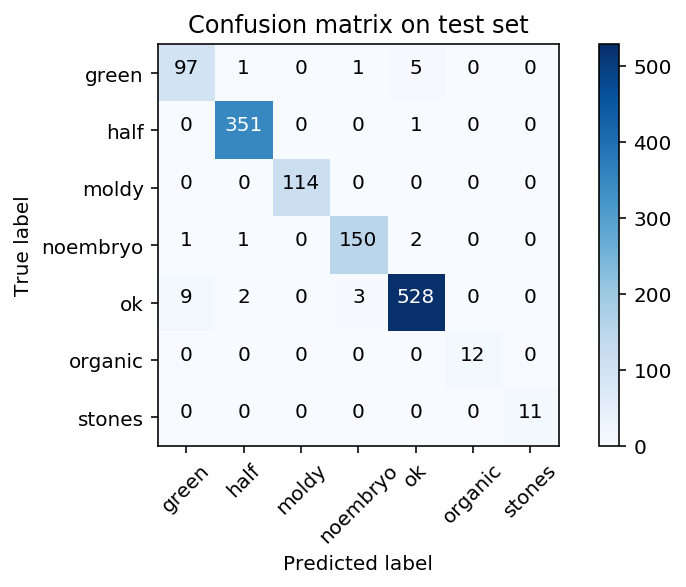

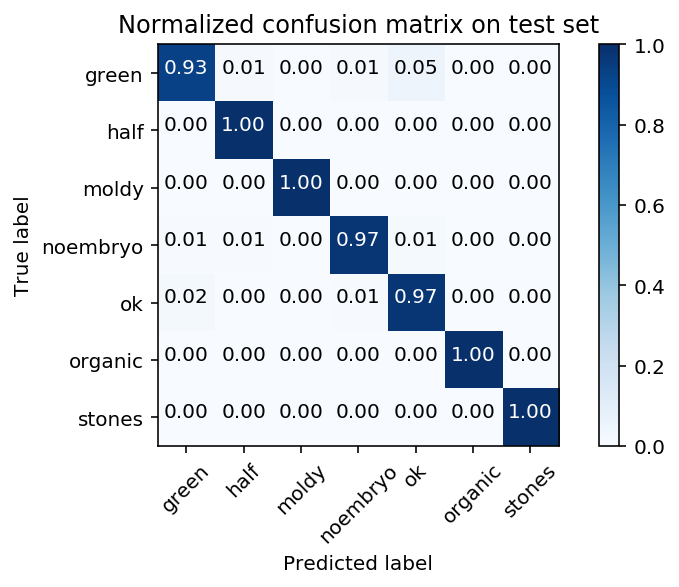

In [9]:
class_names = [key for (key, value) in sorted(test_generator.class_indices.items())]

test_pred = []
for i in prediction:
    test_pred.append(np.argmax(i))

test_cnf_matrix = confusion_matrix(test_generator.classes, test_pred)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names,
                      title='Confusion matrix on test set')
plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix on test set')
plt.show()